<a href="https://colab.research.google.com/github/MarcCampmanyGar/Nuclio_DS_Projects/blob/main/PCA_CF_Anime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a id = "toc"></a>
# Índice
[Objetivos del notebook](#objetivos)

[Importación de las principales librerías](#import_modules)

[Importación de los datos](#import_data)

[Exploratory Data Analysis (EDA)](#eda)

---> [EDA anime df](#df1)

---> [EDA ratings df](#df2)

[Join final animes con ratings de usuarios](#join)

[Reducción de la dimensionalidad con PCA](#pca)

[Elbow curve y KMeans](#elbow_curve)

[Calculate similarity between users and animes reviews](#colaborative_filtering)

[Recomendación "user based"](#recomendacion_usuarios)

[Recomendación "product based"](#recomendacion_animes)

[Conclusión](#conclusión)

<a id = "objetivos"></a>
# Objetivos del notebook
[Volver al índice](#toc)

Una de las áreas del machine learning con la cual intercatuamos casi a diario son los modelos del Collaborative Filtering. En el notebook de hoy, crearemos 2 modelos CF: **uno basando en usuarios (personas similares a ti, han comprado/visto/les ha gustado estas cosas) y otro basado en productos (las personas que han comprado este producto, también han comprado estos).**

El dataset que vamos a utilizar es un dataset de Animes japoneses y se puede descargar en el siguiente [enlace](https://www.kaggle.com/CooperUnion/anime-recommendations-database)
![Data Model](Pictures/Anime.jpg)

Nuestros principales objetivos serán:
1. **Hace una exploración inicial de los dos datasets** y entender la distribución de los datos.



2. **Extraer algunas variables útiles como podrían ser: género de los animes** y eliminar usuarios que no han puntuado los animes.



3. **Reducir la dimensionalidad de nuestro DataFrame utilizando el PCA**


4. **Segmentar nuestros clientes utilizando el dataset reducido**


5. **Utilizar la similitud del coseno para hacer recomendaciones a nuestro clientes (user and product based)**

<a id = "import_modules"></a>
# Importación de las principales librerías
[Volver al índice](#toc)

En esta sección del kernel vamos a cargar las principales librerías que vamos a usar en nuestro notebook.

In [ ]:
# silence warnings
import warnings
warnings.filterwarnings("ignore")

# operating system
import os

# time calculation to track some processes
import time

# numeric and matrix operations
import numpy as np
import pandas as pd

# scientific computations library
import scipy as sp

# loading ploting libraries
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

# import the function to compute cosine_similarity
!pip3 install pickle5
import pickle5 as pickle
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer

PATH_FOLDER = '/content/drive/MyDrive/DATA SCIENCE/Nuclio DS/Machine Learning/Unsupervised/04_PCA_Recomendadores/anime_datasets/'

# PATH_FOLDER = "/contents/"

     |████████████████████████████████| 256 kB 8.2 MB/s 


In [ ]:
PATH_FOLDER

'/content/drive/MyDrive/DATA SCIENCE/Nuclio DS/Machine Learning/Unsupervised/04_PCA_Recomendadores/anime_datasets/'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<a id = "import_data"></a>
# Importación de los datos
[Volver al índice](#toc)

En la presente sección del kernel vamos a cargar los principales datasets que vamos a usar para construir nuestro recomendador.

In [ ]:
PATH_ANIME = (PATH_FOLDER +  'anime.csv')

anime_df = pd.read_csv(PATH_ANIME)

In [ ]:
anime_df.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [ ]:
PATH_RATING = os.path.join(PATH_FOLDER, 'rating.csv')

rating_df = pd.read_csv(PATH_RATING)

In [ ]:
rating_df.sample(10)

,user_id,anime_id,rating
769908,7172,21881,9
833574,7648,31637,8
4664596,44634,14353,9
3769699,35215,28497,8
3299661,30447,2129,9
142314,1441,8074,8
5632079,52879,457,10
7494029,70058,16067,7
2984425,27687,16782,8
577818,5680,856,-1


In [ ]:
VALUE_TO_IMPUTE = -1

<a id = "eda"></a>
# Exploratory Data Analysis (EDA)
[Volver al índice](#toc)

En la sección del EDA haremos **una primera aproximación a nuestros datos** para ver su composición y que variables tenemos a nuestra disposición.

<a id = "df1"></a>
# EDA anime df
[Volver al índice](#toc)

EDA rápido sobre el **dataset de anime.**

In [ ]:
def report_df(df, verbose = True):
    '''
    Hace un report simple sobre el DataFrame suministrado.
    '''
    print(df.info(verbose = verbose))
    total_nulos = df.isnull().sum().sum()
    print()
    print(f"Tenemos un total de {total_nulos} nulos")

In [ ]:
report_df(anime_df)

anime_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB
None

Tenemos un total de 317 nulos


,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


Observamos que tenemos algunos nulos y tendremos que lidiar con ellos.

In [ ]:
anime_df.isnull().sum()

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

No tenemos anime_id duplicados, como era de esperar.

In [ ]:
sum(anime_df["anime_id"].value_counts() > 1)

0

Por tipología de animes, vemos que el más popular es el de TV.

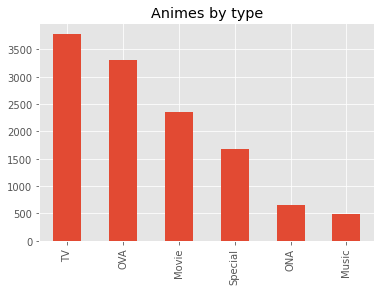

In [ ]:
anime_df["type"].value_counts().plot(kind = "bar", title = "Animes by type");

En nuestro report_df hemos visto que **episodes** parecía que era númerico, pero podría contener otro tipos de datos (por ser object), convertimos a número esta columna.

In [ ]:
anime_df["episodes"] = pd.to_numeric(
    anime_df["episodes"], 
    errors = "coerce"
)
anime_df["episodes"].fillna(1, inplace = True)

In [ ]:
anime_df.max()

anime_id      34527
name              ◯
episodes       1818
rating           10
members     1013917
dtype: object

In [ ]:
anime_df[anime_df["episodes"] == anime_df["episodes"].max()]

,anime_id,name,genre,type,episodes,rating,members
6296,12393,Oyako Club,"Comedy, Slice of Life",TV,1818.0,6.18,160


En la siguiente sección vamos a analizar la distribución de los animes en función del número de episodios que tenían.

In [ ]:
count_per_episodes = anime_df["episodes"].value_counts().to_frame().reset_index()
count_per_episodes.columns = ["nr_episodes", "nr_films"]

In [ ]:
count_per_episodes.sort_values("nr_episodes", ascending = True, inplace = True)
count_per_episodes["pct_over_total"] = count_per_episodes["nr_films"]/count_per_episodes["nr_films"].sum()

In [ ]:
count_per_episodes.head()

,nr_episodes,nr_films,pct_over_total
0,1.0,6017,0.489426
1,2.0,1076,0.087522
5,3.0,505,0.041077
6,4.0,327,0.026598
11,5.0,121,0.009842


Casi la mitad de los animes es de un único episodio (48.94%).

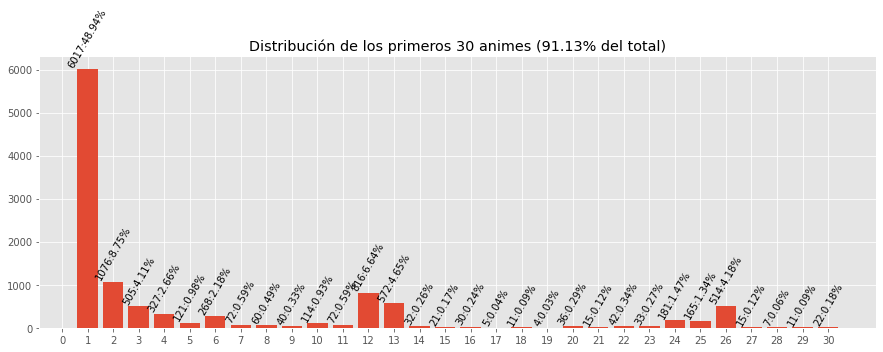

In [ ]:
NR = 30

# instanciate the figure
fig = plt.figure(figsize = (15, 5))
ax = fig.add_subplot(111)

# separete the data
x = count_per_episodes["nr_episodes"].values[:NR]
y = count_per_episodes["nr_films"].values[:NR]
y_pct = count_per_episodes["pct_over_total"].values[:NR]

# plot the data
barplot = ax.bar(x, y)

# add text to each column
for rect, y_pct_ in zip(barplot, y_pct):
    y_pct_ = round(y_pct_*100, 2)
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, f"{height}:{y_pct_}%", ha = 'center', va = "bottom", rotation = 60)

# change the xticks
ax.set_xticks(np.arange(0, NR + 1))

# add title
total_y_pct = round(sum(y_pct)*100, 2)
ax.set_title(f"Distribución de los primeros {NR} animes ({total_y_pct}% del total)");

Vamos a realizar un análisis similar al anterior, pero ahora veremos como se distribuyen los animes en función de la puntuación media.

Para tener sólo 10 grupos, primero vamos a redondear la puntuación media.

In [ ]:
anime_df["rating"].fillna(np.mean(anime_df["rating"]), inplace = True)
anime_df["ceil_rating"] = anime_df["rating"].apply(lambda rating: np.round(rating, 0))

In [ ]:
anime_df[["ceil_rating","rating"]].groupby(["ceil_rating","rating"]).size()

ceil_rating  rating
2.0          1.67      1
             1.92      1
             2.00      1
             2.14      1
             2.37      1
                      ..
9.0          9.33      1
             9.37      1
10.0         9.50      1
             9.60      1
             10.00     1
Length: 599, dtype: int64

La puntuación más común es un 7 y se encuentra en 4.579 animes (37.25% del total).

Text(0.5, 1.0, 'Distribución del número de animes por rating')

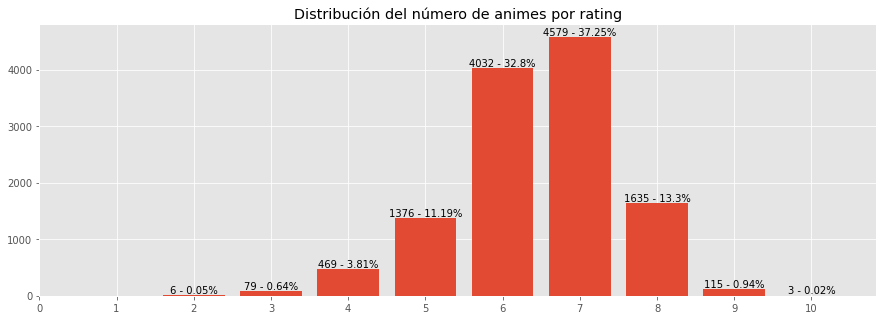

In [ ]:
count_per_rating = anime_df["ceil_rating"].value_counts().to_frame()\
.reset_index().sort_values("index", ascending = True)

# instanciate the figure
fig = plt.figure(figsize = (15, 5))
ax = fig.add_subplot(111)

# separete the data
x = count_per_rating["index"].values
y = count_per_rating["ceil_rating"].values
y_pct = y/sum(y)

# plot the data
barplot = ax.bar(x, y)

# add text to each column
for rect, y_pct_ in zip(barplot, y_pct):
    y_pct_ = round(y_pct_*100, 2)
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, f"{height} - {y_pct_}%", ha = 'center', va = "bottom")
    
ax.set_xticks(np.arange(0, 11))
ax.set_title("Distribución del número de animes por rating")

En esta sección a extraer los géneros de cada anime y lo convertiremos en columnas, que podremos añadir al dataset inicial.

In [ ]:
anime_df["genre"].fillna("Unknown", inplace = True)

In [ ]:
ll = anime_df["genre"].str.split(",").to_list()

In [ ]:
anime_df.head()

,anime_id,name,genre,type,episodes,rating,members,ceil_rating
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1.0,9.37,200630,9.0
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64.0,9.26,793665,9.0
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51.0,9.25,114262,9.0
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24.0,9.17,673572,9.0
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51.0,9.16,151266,9.0


In [ ]:
ll_with_id = []

for ids, lists in zip(list(anime_df["anime_id"].values), ll):
    list_ = [ids]
    for values in lists:
        list_.append(values)
    ll_with_id.append(list_)

In [ ]:
anime_by_genre = pd.DataFrame(ll_with_id)

In [ ]:
anime_by_genre

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,32281,Drama,Romance,School,Supernatural,None,None,None,None,None,None,None,None,None
1,5114,Action,Adventure,Drama,Fantasy,Magic,Military,Shounen,None,None,None,None,None,None
2,28977,Action,Comedy,Historical,Parody,Samurai,Sci-Fi,Shounen,None,None,None,None,None,None
3,9253,Sci-Fi,Thriller,None,None,None,None,None,None,None,None,None,None,None
4,9969,Action,Comedy,Historical,Parody,Samurai,Sci-Fi,Shounen,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12289,9316,Hentai,None,None,None,None,None,None,None,None,None,None,None,None
12290,5543,Hentai,None,None,None,None,None,None,None,None,None,None,None,None
12291,5621,Hentai,None,None,None,None,None,None,None,None,None,None,None,None
12292,6133,Hentai,None,None,None,None,None,None,None,None,None,None,None,None


In [ ]:
anime_by_genre = pd.DataFrame(ll_with_id).melt(id_vars = 0)
anime_by_genre["value"].fillna("Unknown", inplace = True)
anime_by_genre.rename(columns = {0:"anime_id"}, inplace = True)
anime_by_genre.head()

,anime_id,variable,value
0,32281,1,Drama
1,5114,1,Action
2,28977,1,Action
3,9253,1,Sci-Fi
4,9969,1,Action


In [ ]:
anime_by_genre[anime_by_genre['anime_id'] == 32281]

,anime_id,variable,value
0,32281,1,Drama
12294,32281,2,Romance
24588,32281,3,School
36882,32281,4,Supernatural
49176,32281,5,Unknown
61470,32281,6,Unknown
73764,32281,7,Unknown
86058,32281,8,Unknown
98352,32281,9,Unknown
110646,32281,10,Unknown


In [ ]:
anime_by_genre = anime_by_genre.pivot_table(index = "anime_id", columns = "value", aggfunc = len, fill_value = 0)
anime_by_genre.head()

variable                          ...                              
value     Adventure  Cars  Comedy  Dementia  ... Thriller Unknown Vampire Yaoi
anime_id                                     ...                              
1                 1     0       1         0  ...        0       7       0    0
5                 0     0       0         0  ...        0       8       0    0
6                 0     0       1         0  ...        0      10       0    0
7                 0     0       0         0  ...        0       7       0    0
8                 0     0       0         0  ...        0       9       0    0

[5 rows x 83 columns]

In [ ]:
new_columns = [tupple[1] for tupple in list(anime_by_genre.columns)]
new_columns = list(map(lambda text: text[1:] if text[0] == " " else text, new_columns))

In [ ]:
anime_by_genre.columns = new_columns
anime_by_genre.reset_index(inplace = True)
anime_by_genre.head()

,anime_id,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,Fantasy,Game,Harem,Hentai,Historical,Horror,Josei,Kids,Magic,Martial Arts,Mecha,Military,Music,Mystery,Parody,Police,Psychological,Romance,Samurai,School,Sci-Fi,Seinen,Shoujo,Shoujo Ai,Shounen,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,...,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,Fantasy,Game,Harem,Hentai,Historical,Horror,Josei,Kids,Magic,Martial Arts,Mecha,Military,Music,Mystery,Parody,Police,Psychological,Romance,Samurai,School,Sci-Fi,Seinen,Shoujo,Shounen,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Unknown,Vampire,Yaoi
0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,0,0
1,5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,0,0
2,6,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,0,0
3,7,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,0,0
4,8,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,0,0


In [ ]:
anime_df.shape[0] == anime_by_genre.shape[0]

True

No vamos a añadir las columnas para tener un dataset más fácil de manejar.

In [ ]:
# anime_df = pd.merge(anime_df, anime_by_genre, how = "left", on = ["anime_id"])

In [ ]:
anime_df.head()

,anime_id,name,genre,type,episodes,rating,members,ceil_rating
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1.0,9.37,200630,9.0
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64.0,9.26,793665,9.0
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51.0,9.25,114262,9.0
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24.0,9.17,673572,9.0
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51.0,9.16,151266,9.0


<a id = "df2"></a>
# EDA ratings df
[Volver al índice](#toc)

EDA rápido sobre el DataFrame de **ratings de los animes.**

In [ ]:
report_df(rating_df)

rating_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB
None

Tenemos un total de 0 nulos


,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


Observamos que tenemor **casi un 20% de animes sin reviews.**

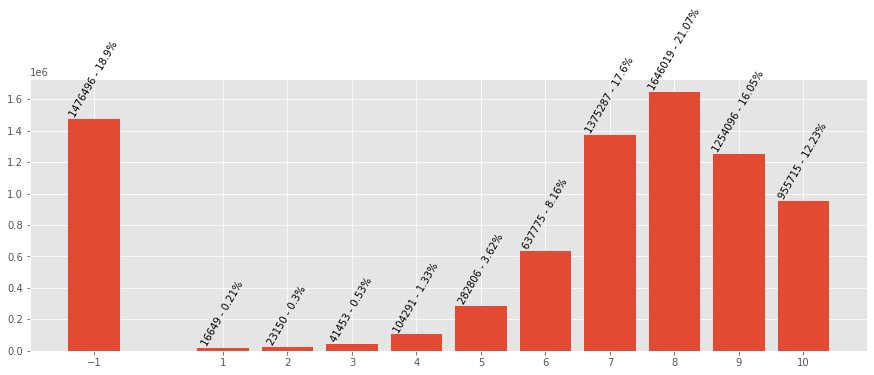

In [ ]:
rating_gb = rating_df["rating"].value_counts().reset_index().sort_values("index", ascending = True)
rating_gb.sort_values("index", ascending = True, inplace = True)

fig = plt.figure(figsize = (15, 5))
ax = fig.add_subplot()

x = rating_gb["index"]
y = rating_gb["rating"]
y_pct = y/sum(y)

barplot = ax.bar(x, y)

# add text to each column
for rect, y_pct_ in zip(barplot, y_pct):
    y_pct_ = round(y_pct_*100, 2)
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, f"{height} - {y_pct_}%", ha = 'center', va = "bottom", rotation = 60)

ax.set_xticks(x);

Vamos a ver los usuarios con más reviews.

In [ ]:
user_pivot = rating_df["user_id"].value_counts()
user_pivot.head()

48766    10227
42635     3747
53698     2905
57620     2702
59643     2633
Name: user_id, dtype: int64

In [ ]:
# el usuario 48766 es claramente un usuario "raro" tiene más de 10k reviews, pero todos son nulos.
rating_df[rating_df["user_id"] == 48766].shape[0] == -rating_df[rating_df["user_id"] == 48766]["rating"].sum()

True

In [ ]:
print(rating_df[rating_df["user_id"] == 48766].shape[0])
print(rating_df[rating_df["user_id"] == 48766]["rating"].sum())

10227
-10227


Vamos a eliminar de nuestro DataFrame a todos aquellos usuarios que han puntuado a todos -1

In [ ]:
s = rating_df.groupby('user_id')['rating'].apply(set)

In [ ]:
s

user_id
1                                   {10, -1}
2                                   {10, -1}
3              {3, 4, 5, 6, 7, 8, 9, 10, -1}
4                                       {-1}
5        {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, -1}
                        ...                 
73512                   {5, 7, 8, 9, 10, -1}
73513                    {5, 6, 7, 8, 9, 10}
73514                                   {10}
73515                {5, 6, 7, 8, 9, 10, -1}
73516                                    {9}
Name: rating, Length: 73515, dtype: object

In [ ]:
user_id_no_reviews = s.to_frame()[s.to_frame()["rating"] == {-1}].index

In [ ]:
user_id_no_reviews

Int64Index([    4,     6,    13,    49,    54,    89,   133,   151,   157,
              188,
            ...
            73296, 73300, 73335, 73407, 73411, 73418, 73447, 73451, 73467,
            73475],
           dtype='int64', name='user_id', length=3915)

In [ ]:
rating_df = rating_df[-rating_df["user_id"].isin(user_id_no_reviews)]

In [ ]:
rating_df[rating_df["user_id"] == 1]["rating"].value_counts()

-1     149
 10      4
Name: rating, dtype: int64

<a id = "join"></a>
# Join final animes con ratings de usuarios
[Volver al índice](#toc)

Una vez que hemos analizado nuestros DataFrames, vamos a hacer un join **por anime_id.**

In [ ]:
rating_df.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [ ]:
anime_df.head()

,anime_id,name,genre,type,episodes,rating,members,ceil_rating
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1.0,9.37,200630,9.0
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64.0,9.26,793665,9.0
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51.0,9.25,114262,9.0
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24.0,9.17,673572,9.0
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51.0,9.16,151266,9.0


In [ ]:
rating_df.rename(columns = {"rating":"user_rating"}, inplace = True)
anime_df.rename(columns = {"rating":"average_rating"}, inplace = True)
df_final = pd.merge(rating_df, anime_df, on = "anime_id")

In [ ]:
df_final.head()

,user_id,anime_id,user_rating,name,genre,type,episodes,average_rating,members,ceil_rating
0,1,20,NaN,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220.0,7.81,683297,8.0
1,3,20,8.0,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220.0,7.81,683297,8.0
2,5,20,6.0,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220.0,7.81,683297,8.0
3,10,20,NaN,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220.0,7.81,683297,8.0
4,21,20,8.0,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220.0,7.81,683297,8.0


In [ ]:
df_final["user_rating"].replace(-1, np.nan, inplace = True)

Filtramos sólo por type == TV para tener una dataset más manejable.

In [ ]:
df_final = df_final[df_final["type"] == "TV"]

In [ ]:
df_final = df_final.pivot_table(index = "user_id", columns = "name", values = "user_rating")

In [ ]:
df_final.head()

name,.hack//Roots,.hack//Sign,.hack//Tasogare no Udewa Densetsu,009-1,07-Ghost,11eyes,12-sai.: Chicchana Mune no Tokimeki,12-sai.: Chicchana Mune no Tokimeki 2nd Season,2020 Nyeon Ujuui Wonder Kiddy,21 Emon,3 Choume no Tama: Uchi no Tama Shirimasenka?,30-sai no Hoken Taiiku,91 Days,A-Channel,A-jang.com,A.D. Police (TV),AKB0048,AKB0048: Next Stage,AWOL,Aa Harimanada,Aa! Megami-sama! (TV),Aa! Megami-sama!: Chichaitte Koto wa Benri da ne,Aa! Megami-sama!: Sorezore no Tsubasa,Abarenbou Rikishi!! Matsutarou,Abenobashi Mahou☆Shoutengai,Absolute Duo,Accel World,Acchi Kocchi (TV),Ace wo Nerae!,Active Raid: Kidou Kyoushuushitsu Dai Hachi Gakari,Active Raid: Kidou Kyoushuushitsu Dai Hachi Gakari 2nd,Aesop&#039;s World,Afro Samurai,After War Gundam X,Agatha Christie no Meitantei Poirot to Marple,Agigongryong Doolie,Agigongryong Doolie (2009),Ai Shoujo Pollyanna Story,Ai Tenchi Muyou!,Ai Tenshi Densetsu Wedding Peach,...,Z/X: Ignition,Zan Sayonara Zetsubou Sensei,Zankyou no Terror,Zegapain,Zenmai Zamurai,Zenryoku Usagi,Zero Duel Masters,Zero Tester,Zero Tester: Chikyuu wo Mamore!,Zero no Tsukaima,Zero no Tsukaima F,Zero no Tsukaima: Futatsuki no Kishi,Zero no Tsukaima: Princesses no Rondo,Zetman,Zetsuen no Tempest,Zettai Bouei Leviathan,Zettai Karen Children,Zettai Karen Children: The Unlimited - Hyoubu Kyousuke,Zettai Muteki Raijin-Oh,Zettai Shounen,Zettai Yareru Greece Shinwa,Zipang,Zoids,Zoids Fuzors,Zoids Genesis,Zoids Shinseiki/Zero,Zoku Attacker You! Kin Medal e no Michi,Zoku Natsume Yuujinchou,Zoku Sayonara Zetsubou Sensei,Zombie-Loan,"Zone of the Enders: Dolores, I",Zukkoke Knight: Don De La Mancha,ef: A Tale of Melodies.,ef: A Tale of Memories.,gdgd Fairies,gdgd Fairies 2,iDOLM@STER Xenoglossia,s.CRY.ed,xxxHOLiC,xxxHOLiC Kei
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
VALUE_TO_IMPUTE

-1

In [ ]:
if VALUE_TO_IMPUTE != "MEAN":
    df_final.fillna(VALUE_TO_IMPUTE, inplace = True)

elif VALUE_TO_IMPUTE == "MEAN":
    imputer = SimpleImputer(strategy = "mean")
    X_imputed = imputer.fit_transform(df_final)
    df_final = pd.DataFrame(X_imputed, index = df_final.index, columns = df_final.columns)

In [ ]:
df_final.head()

name,.hack//Roots,.hack//Sign,.hack//Tasogare no Udewa Densetsu,009-1,07-Ghost,11eyes,12-sai.: Chicchana Mune no Tokimeki,12-sai.: Chicchana Mune no Tokimeki 2nd Season,2020 Nyeon Ujuui Wonder Kiddy,21 Emon,3 Choume no Tama: Uchi no Tama Shirimasenka?,30-sai no Hoken Taiiku,91 Days,A-Channel,A-jang.com,A.D. Police (TV),AKB0048,AKB0048: Next Stage,AWOL,Aa Harimanada,Aa! Megami-sama! (TV),Aa! Megami-sama!: Chichaitte Koto wa Benri da ne,Aa! Megami-sama!: Sorezore no Tsubasa,Abarenbou Rikishi!! Matsutarou,Abenobashi Mahou☆Shoutengai,Absolute Duo,Accel World,Acchi Kocchi (TV),Ace wo Nerae!,Active Raid: Kidou Kyoushuushitsu Dai Hachi Gakari,Active Raid: Kidou Kyoushuushitsu Dai Hachi Gakari 2nd,Aesop&#039;s World,Afro Samurai,After War Gundam X,Agatha Christie no Meitantei Poirot to Marple,Agigongryong Doolie,Agigongryong Doolie (2009),Ai Shoujo Pollyanna Story,Ai Tenchi Muyou!,Ai Tenshi Densetsu Wedding Peach,...,Z/X: Ignition,Zan Sayonara Zetsubou Sensei,Zankyou no Terror,Zegapain,Zenmai Zamurai,Zenryoku Usagi,Zero Duel Masters,Zero Tester,Zero Tester: Chikyuu wo Mamore!,Zero no Tsukaima,Zero no Tsukaima F,Zero no Tsukaima: Futatsuki no Kishi,Zero no Tsukaima: Princesses no Rondo,Zetman,Zetsuen no Tempest,Zettai Bouei Leviathan,Zettai Karen Children,Zettai Karen Children: The Unlimited - Hyoubu Kyousuke,Zettai Muteki Raijin-Oh,Zettai Shounen,Zettai Yareru Greece Shinwa,Zipang,Zoids,Zoids Fuzors,Zoids Genesis,Zoids Shinseiki/Zero,Zoku Attacker You! Kin Medal e no Michi,Zoku Natsume Yuujinchou,Zoku Sayonara Zetsubou Sensei,Zombie-Loan,"Zone of the Enders: Dolores, I",Zukkoke Knight: Don De La Mancha,ef: A Tale of Melodies.,ef: A Tale of Memories.,gdgd Fairies,gdgd Fairies 2,iDOLM@STER Xenoglossia,s.CRY.ed,xxxHOLiC,xxxHOLiC Kei
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,7.0,-1.0,-1.0,-1.0,-1.0,-1.0,6.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,8.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,7.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
5,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2.0,3.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,7.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,7.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2.0,-1.0
7,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,8.0,8.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [ ]:
df_final.shape

(68929, 3069)

<a id = "pca"></a>
# Reducción de la dimensionalidad con PCA
[Volver al índice](#toc)

El PCA es el método más utilizado de reducción de la dimensionalidad y con una largo desarrollo teórico detrás (fue [inventado en 1901](https://en.wikipedia.org/wiki/Principal_component_analysis) por Karl Pearson.

La idea básica detrás del PCA es la proyección de un dataset con **n** dimensiones a otro **m** dimensiones, donde **n > m** , de tal forma que el dataset en el nuevo espacio conserva la máxima cantidad de inforamción (varianza) del espacio original. Por tanto, el nuevo dataset reducido, es una combinación lineal de las **n** dimensiones originales.

Cuando inicializamos el PCA de sklearn, le tenemos que especificar el número de componentes que queremos que tenga nuestro nuevo dataset. 

In [ ]:
st = time.time()
pca = PCA(n_components = 30)
pca.fit(df_final)
pca_samples = pca.transform(df_final)
et = time.time()
print("Total PCA took {} minutes".format(round((et - st)/60, 2)))

Total PCA took 0.35 minutes


In [ ]:
pca.explained_variance_ratio_

array([0.13847638, 0.04037278, 0.02560091, 0.01881841, 0.01816565,
       0.01580459, 0.01046155, 0.00933587, 0.00895123, 0.00751564,
       0.00689667, 0.00662744, 0.00604305, 0.00558263, 0.00507921,
       0.00478807, 0.00462392, 0.00452888, 0.00436462, 0.00428975,
       0.00411415, 0.00394215, 0.00373537, 0.00370532, 0.00363266,
       0.00345207, 0.00339594, 0.00325336, 0.00321294, 0.00314388])

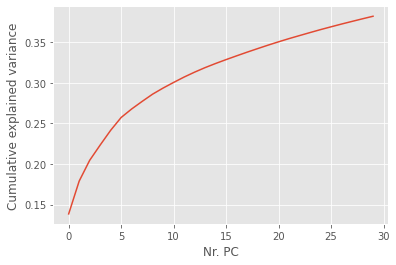

In [ ]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Nr. PC')
plt.ylabel('Cumulative explained variance');

In [ ]:
pca_df = pd.DataFrame(pca_samples[:, 0:20])

In [ ]:
pca_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-18.083291,-6.214738,6.339123,-2.077502,-0.578123,0.440503,2.298638,-0.581077,-1.369166,-2.925437,0.381675,2.430573,-1.103155,-0.439943,1.262120,0.993645,3.860800,4.309602,-0.700490,-2.299178
1,-20.828248,-4.411492,4.206292,1.769552,0.729081,3.984481,2.932304,1.617382,-3.473776,0.519014,-1.216947,1.547279,-0.054735,0.318518,0.169221,-0.763016,-2.150783,1.310896,-0.544045,-1.218240
2,4.463697,-18.506785,-17.698568,-9.951515,-12.938263,0.888891,-1.134637,10.751295,6.427173,2.836863,-2.273455,16.041718,-4.049118,2.810408,-1.666050,-3.219968,3.295267,-2.405052,4.745116,2.715856
3,32.001081,-8.481056,1.714675,0.618708,1.182141,15.527692,11.087207,33.256516,8.195695,-7.697199,-7.319920,-1.759493,2.019459,0.764466,-0.036552,-10.628608,-7.790747,9.608179,-1.555956,7.911849
4,39.986673,-16.686275,19.739166,-10.329925,5.570900,17.771578,-11.567094,1.245722,32.004351,11.059341,5.826546,-12.322184,10.374862,4.632636,2.373518,-5.127467,2.373890,17.496467,-3.973798,8.453230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68924,-15.869116,-0.401760,8.090987,6.259737,-0.484376,0.696388,-3.713264,0.923830,-4.055205,2.222989,-0.660207,-1.370852,-4.345699,-4.475126,0.693926,-4.236335,-3.239089,-1.214049,7.188127,-5.476318
68925,-18.796852,1.736515,2.921364,3.062962,0.412888,4.950713,-1.360767,-3.206884,0.782292,-1.676885,1.593068,0.850168,1.589494,-1.578573,1.223687,-1.843570,-0.505503,1.153120,-0.845828,0.330186
68926,-14.924715,5.977005,6.573324,0.173151,5.252500,5.757670,-2.847497,0.205089,-4.684575,-1.953346,0.528201,1.403507,-3.575256,-1.011409,-0.595914,-2.140437,-5.543488,-0.284734,2.730028,0.116074
68927,15.948505,28.151414,-14.146337,-21.277459,-1.916958,0.107786,22.120441,-16.828786,-1.001135,-2.738016,5.503289,-4.845200,5.665673,1.076838,-7.712094,0.617437,6.497900,2.803001,-2.321770,-7.407172


Como era de esperar, el dataset proyectado, "pierde" información al realizar la transformación. 

Otra forma de inicializar el PCA, es en vez de especificar el número de componentes, decir al PCA cuanta varianza mínima del dataset original debe contener (tiene que ser un número entre 0 - 1).

pca = PCA(n_components = 0.3)

<a id = "elbow_curve"></a>
# Elbow curve y KMeans
[Volver al índice](#toc)

Dado que ahora podemos reducir nuestro dataset. Podemos utilizar el algoritmo KMeans y segmentar a nuestros clientes utilizando el pca_df.

In [ ]:
st = time.time()

sse = {}

for k in range(1,10):
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(pca_df)
    sse[k] = kmeans.inertia_
    
et = time.time()
print("Total Elbow curve took {} minutes".format(round((et - st)/60, 2)))

Total Elbow curve took 0.78 minutes


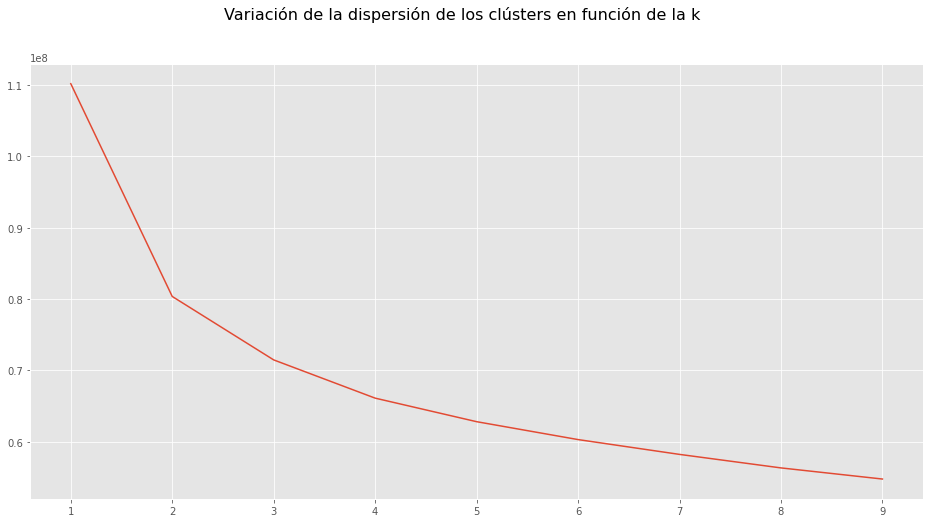

In [ ]:
fig = plt.figure(figsize = (16, 8))
ax = fig.add_subplot()

x_values = list(sse.keys())
y_values = list(sse.values())

ax.plot(x_values, y_values, label = "Inertia/dispersión de los clústers")
ax.set_xticks(np.arange(1, 10))
fig.suptitle("Variación de la dispersión de los clústers en función de la k", fontsize = 16);

In [ ]:
kmeans = KMeans(n_clusters = 4)
kmeans.fit(pca_df)
pca_df['cluster'] = kmeans.labels_

In [ ]:
pca_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,cluster
0,-18.083291,-6.214738,6.339123,-2.077502,-0.578123,0.440503,2.298638,-0.581077,-1.369166,-2.925437,0.381675,2.430573,-1.103155,-0.439943,1.262120,0.993645,3.860800,4.309602,-0.700490,-2.299178,0
1,-20.828248,-4.411492,4.206292,1.769552,0.729081,3.984481,2.932304,1.617382,-3.473776,0.519014,-1.216947,1.547279,-0.054735,0.318518,0.169221,-0.763016,-2.150783,1.310896,-0.544045,-1.218240,0
2,4.463697,-18.506785,-17.698568,-9.951515,-12.938263,0.888891,-1.134637,10.751295,6.427173,2.836863,-2.273455,16.041718,-4.049118,2.810408,-1.666050,-3.219968,3.295267,-2.405052,4.745116,2.715856,3
3,32.001081,-8.481056,1.714675,0.618708,1.182141,15.527692,11.087207,33.256516,8.195695,-7.697199,-7.319920,-1.759493,2.019459,0.764466,-0.036552,-10.628608,-7.790747,9.608179,-1.555956,7.911849,3
4,39.986673,-16.686275,19.739166,-10.329925,5.570900,17.771578,-11.567094,1.245722,32.004351,11.059341,5.826546,-12.322184,10.374862,4.632636,2.373518,-5.127467,2.373890,17.496467,-3.973798,8.453230,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68924,-15.869116,-0.401760,8.090987,6.259737,-0.484376,0.696388,-3.713264,0.923830,-4.055205,2.222989,-0.660207,-1.370852,-4.345699,-4.475126,0.693926,-4.236335,-3.239089,-1.214049,7.188127,-5.476318,0
68925,-18.796852,1.736515,2.921364,3.062962,0.412888,4.950713,-1.360767,-3.206884,0.782292,-1.676885,1.593068,0.850168,1.589494,-1.578573,1.223687,-1.843570,-0.505503,1.153120,-0.845828,0.330186,0
68926,-14.924715,5.977005,6.573324,0.173151,5.252500,5.757670,-2.847497,0.205089,-4.684575,-1.953346,0.528201,1.403507,-3.575256,-1.011409,-0.595914,-2.140437,-5.543488,-0.284734,2.730028,0.116074,0
68927,15.948505,28.151414,-14.146337,-21.277459,-1.916958,0.107786,22.120441,-16.828786,-1.001135,-2.738016,5.503289,-4.845200,5.665673,1.076838,-7.712094,0.617437,6.497900,2.803001,-2.321770,-7.407172,1


In [ ]:
# sns.pairplot(pca_df, vars = [0, 1, 2], hue = 'cluster');

In [ ]:
df_final["cluster"] = kmeans.labels_

In [ ]:
df_final

name,.hack//Roots,.hack//Sign,.hack//Tasogare no Udewa Densetsu,009-1,07-Ghost,11eyes,12-sai.: Chicchana Mune no Tokimeki,12-sai.: Chicchana Mune no Tokimeki 2nd Season,2020 Nyeon Ujuui Wonder Kiddy,21 Emon,3 Choume no Tama: Uchi no Tama Shirimasenka?,30-sai no Hoken Taiiku,91 Days,A-Channel,A-jang.com,A.D. Police (TV),AKB0048,AKB0048: Next Stage,AWOL,Aa Harimanada,Aa! Megami-sama! (TV),Aa! Megami-sama!: Chichaitte Koto wa Benri da ne,Aa! Megami-sama!: Sorezore no Tsubasa,Abarenbou Rikishi!! Matsutarou,Abenobashi Mahou☆Shoutengai,Absolute Duo,Accel World,Acchi Kocchi (TV),Ace wo Nerae!,Active Raid: Kidou Kyoushuushitsu Dai Hachi Gakari,Active Raid: Kidou Kyoushuushitsu Dai Hachi Gakari 2nd,Aesop&#039;s World,Afro Samurai,After War Gundam X,Agatha Christie no Meitantei Poirot to Marple,Agigongryong Doolie,Agigongryong Doolie (2009),Ai Shoujo Pollyanna Story,Ai Tenchi Muyou!,Ai Tenshi Densetsu Wedding Peach,...,Zan Sayonara Zetsubou Sensei,Zankyou no Terror,Zegapain,Zenmai Zamurai,Zenryoku Usagi,Zero Duel Masters,Zero Tester,Zero Tester: Chikyuu wo Mamore!,Zero no Tsukaima,Zero no Tsukaima F,Zero no Tsukaima: Futatsuki no Kishi,Zero no Tsukaima: Princesses no Rondo,Zetman,Zetsuen no Tempest,Zettai Bouei Leviathan,Zettai Karen Children,Zettai Karen Children: The Unlimited - Hyoubu Kyousuke,Zettai Muteki Raijin-Oh,Zettai Shounen,Zettai Yareru Greece Shinwa,Zipang,Zoids,Zoids Fuzors,Zoids Genesis,Zoids Shinseiki/Zero,Zoku Attacker You! Kin Medal e no Michi,Zoku Natsume Yuujinchou,Zoku Sayonara Zetsubou Sensei,Zombie-Loan,"Zone of the Enders: Dolores, I",Zukkoke Knight: Don De La Mancha,ef: A Tale of Melodies.,ef: A Tale of Memories.,gdgd Fairies,gdgd Fairies 2,iDOLM@STER Xenoglossia,s.CRY.ed,xxxHOLiC,xxxHOLiC Kei,cluster
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0
2,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0
3,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,7.0,-1.0,-1.0,-1.0,-1.0,-1.0,6.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,8.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,7.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,3
5,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2.0,3.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,7.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,7.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2.0,-1.0,3
7,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,8.0,8.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

Ahora tenemos, a nuestros clientes **segmentados** y podemos llegar a plantear un recommendador de animes, en base al clúster que pertenece cada persona.

In [ ]:
df_final.groupby("cluster").size()

cluster
0    44802
1     8037
2     3859
3    12231
dtype: int64

In [ ]:
df_final["cluster"] = df_final["cluster"] + 1

In [ ]:
df_final.groupby("cluster").size()

cluster
1    44802
2     8037
3     3859
4    12231
dtype: int64

In [ ]:
df_cluster_1 = df_final[df_final["cluster"] == 1]

In [ ]:
if VALUE_TO_IMPUTE != "MEAN":
    df_cluster_1.replace([VALUE_TO_IMPUTE], np.nan, inplace = True)

elif VALUE_TO_IMPUTED == "MEAN":
    imputed_values = imputer.statistics_

    for col_idx, imputed_value in enumerate(imputed_values):
        df_cluster_1.iloc[:,col_idx] = df_cluster_1.iloc[:,col_idx].replace([imputed_value], np.nan)

In [ ]:
df_cluster_1_sample = df_cluster_1.sample(1000)

In [ ]:
df_cluster_1_sample

name,.hack//Roots,.hack//Sign,.hack//Tasogare no Udewa Densetsu,009-1,07-Ghost,11eyes,12-sai.: Chicchana Mune no Tokimeki,12-sai.: Chicchana Mune no Tokimeki 2nd Season,2020 Nyeon Ujuui Wonder Kiddy,21 Emon,3 Choume no Tama: Uchi no Tama Shirimasenka?,30-sai no Hoken Taiiku,91 Days,A-Channel,A-jang.com,A.D. Police (TV),AKB0048,AKB0048: Next Stage,AWOL,Aa Harimanada,Aa! Megami-sama! (TV),Aa! Megami-sama!: Chichaitte Koto wa Benri da ne,Aa! Megami-sama!: Sorezore no Tsubasa,Abarenbou Rikishi!! Matsutarou,Abenobashi Mahou☆Shoutengai,Absolute Duo,Accel World,Acchi Kocchi (TV),Ace wo Nerae!,Active Raid: Kidou Kyoushuushitsu Dai Hachi Gakari,Active Raid: Kidou Kyoushuushitsu Dai Hachi Gakari 2nd,Aesop&#039;s World,Afro Samurai,After War Gundam X,Agatha Christie no Meitantei Poirot to Marple,Agigongryong Doolie,Agigongryong Doolie (2009),Ai Shoujo Pollyanna Story,Ai Tenchi Muyou!,Ai Tenshi Densetsu Wedding Peach,...,Zan Sayonara Zetsubou Sensei,Zankyou no Terror,Zegapain,Zenmai Zamurai,Zenryoku Usagi,Zero Duel Masters,Zero Tester,Zero Tester: Chikyuu wo Mamore!,Zero no Tsukaima,Zero no Tsukaima F,Zero no Tsukaima: Futatsuki no Kishi,Zero no Tsukaima: Princesses no Rondo,Zetman,Zetsuen no Tempest,Zettai Bouei Leviathan,Zettai Karen Children,Zettai Karen Children: The Unlimited - Hyoubu Kyousuke,Zettai Muteki Raijin-Oh,Zettai Shounen,Zettai Yareru Greece Shinwa,Zipang,Zoids,Zoids Fuzors,Zoids Genesis,Zoids Shinseiki/Zero,Zoku Attacker You! Kin Medal e no Michi,Zoku Natsume Yuujinchou,Zoku Sayonara Zetsubou Sensei,Zombie-Loan,"Zone of the Enders: Dolores, I",Zukkoke Knight: Don De La Mancha,ef: A Tale of Melodies.,ef: A Tale of Memories.,gdgd Fairies,gdgd Fairies 2,iDOLM@STER Xenoglossia,s.CRY.ed,xxxHOLiC,xxxHOLiC Kei,cluster
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
64415,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
60203,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
46741,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
63500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
65740,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47251,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [ ]:
df_cluster_1_sample.drop('cluster', axis=1, inplace=True)

In [ ]:
df_cluster_1_sample.shape

(1000, 3069)

In [ ]:
df_cluster_1_sample_melted = df_cluster_1_sample.melt()

In [ ]:
df_cluster_1_sample_melted = df_cluster_1_sample_melted.dropna()

In [ ]:
df_cluster_1_sample_melted.head(10)

,name,value
168,.hack//Roots,9.0
463,.hack//Roots,7.0
683,.hack//Roots,8.0
877,.hack//Roots,8.0
910,.hack//Roots,7.0
1007,.hack//Sign,9.0
1076,.hack//Sign,9.0
1149,.hack//Sign,6.0
1168,.hack//Sign,8.0
1176,.hack//Sign,7.0


In [ ]:
gbdf = df_cluster_1_sample_melted.groupby('name')

In [ ]:
gbdf.get_group(('.hack//Roots'))

,name,value
168,.hack//Roots,9.0
463,.hack//Roots,7.0
683,.hack//Roots,8.0
877,.hack//Roots,8.0
910,.hack//Roots,7.0


In [ ]:
df_cluster_1_sample_melted.groupby('name')['value'].mean().to_frame()

# se muestran los ratings medios de cada serie, puestos por la gente del cluster 1.

,value
name,
.hack//Roots,7.800000
.hack//Sign,7.681818
.hack//Tasogare no Udewa Densetsu,7.230769
07-Ghost,8.391304
11eyes,7.448276
...,...
ef: A Tale of Memories.,7.611111
iDOLM@STER Xenoglossia,2.000000
s.CRY.ed,8.083333


In [ ]:
average_score_cluster_1 = df_cluster_1.melt().groupby("name")["value"].mean()

# para sacar las valoraciones media por anime de la gente del mismo cluster

In [ ]:
average_score_cluster_1.reset_index().sort_values("value", ascending = False)

,name,value
2035,Oshiri Kajiri Mushi (TV) 4th Season,10.0
2416,Shin Ace wo Nerae!,10.0
350,Card Wang: Mix Master,10.0
1698,Mazinger ZIP!,10.0
72,Akubi Girl,10.0
...,...,...
2982,Yoshimune,NaN
2988,Yousei Dick,NaN
3033,Zenmai Zamurai,NaN
3049,Zettai Yareru Greece Shinwa,NaN


<a id = "colaborative_filtering"></a>
# Calculate similarity between users and animes reviews
[Volver al índice](#toc)

En la presente sección vamos a calcular la similitud de cosen para 4000 clientes (y los productos que han evaluado).

In [ ]:
CALCULATE_SIMILARITY = False

In [ ]:
if CALCULATE_SIMILARITY:

    st = time.time()
    df_final_norm = df_final.apply(lambda x: (x - np.mean(x))/(np.max(x) - np.min(x)), axis = 1)
    et = time.time()
    print("Normalization took {} minutes".format(round((et - st)/60, 2)))

    df_final_norm = df_final_norm[df_final_norm.index < 3000]
    sparse_ratings = sp.sparse.csr_matrix(df_final_norm.values)

    st = time.time()
    
    item_similarity = cosine_similarity(sparse_ratings.T)
    item_sim_df = pd.DataFrame(item_similarity, index = df_final_norm.columns, columns = df_final_norm.columns)
    item_sim_df.to_pickle(os.path.join(PATH_FOLDER, "item_similarity.pkl"))

    user_similarity = cosine_similarity(sparse_ratings)
    user_sim_df = pd.DataFrame(user_similarity, index = df_final_norm.index, columns = df_final_norm.index)
    user_sim_df.to_pickle(os.path.join(PATH_FOLDER, "user_similarity.pkl"))
    
    et = time.time()
    print("Total time to calculate similarity took {} minutes.".format(round((et - st)/60, 2)))
    
else:
    user_sim_df = pd.read_pickle('/content/drive/MyDrive/DATA SCIENCE/Nuclio DS/Machine Learning/Unsupervised/04_PCA_Recomendadores/anime_datasets/user_similarity.pkl')
    item_sim_df = pd.read_pickle('/content/drive/MyDrive/DATA SCIENCE/Nuclio DS/Machine Learning/Unsupervised/04_PCA_Recomendadores/anime_datasets/item_similarity.pkl')

Normalization took 1.38 minutes
Total time to calculate similarity took 2.3 minutes.


In [ ]:
user_sim_df.head()
# matriz que cruza clientes con clientes para ver su similitud con la similitud de coseno

user_id,1,2,3,5,7,8,9,10,11,12,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,36,37,38,39,40,41,42,43,44,...,2957,2958,2959,2960,2961,2962,2963,2964,2965,2966,2967,2968,2970,2971,2972,2973,2974,2975,2976,2977,2979,2980,2981,2982,2983,2984,2985,2986,2987,2988,2989,2990,2991,2992,2993,2994,2995,2996,2998,2999
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.015421,0.118754,0.043554,0.092913,0.155380,0.018848,0.285371,0.067318,0.196772,0.089180,0.016973,0.005395,0.118731,0.001719,0.004970,0.002928,-0.003161,0.006794,-0.002647,0.179914,0.097826,0.008786,0.250069,0.153150,0.192414,0.186182,0.083413,0.002980,0.002922,0.001503,0.006180,0.139766,0.114632,0.001699,0.083023,0.240651,0.005629,0.090880,-0.000294,...,0.000455,0.056244,-0.000880,0.065054,0.001686,0.002767,0.004828,0.063966,0.004454,0.249852,0.009492,0.048305,0.000013,0.083178,-0.000586,-0.001569,0.040733,0.065845,0.018848,0.021156,0.012279,0.219320,0.047208,0.240345,0.006794,0.001199,0.273206,0.209978,0.221527,0.197003,0.134725,0.104800,0.235724,-0.000456,0.550648,0.245313,0.006191,0.004567,0.199182,0.036518
2,0.015421,1.000000,0.160152,0.002607,-0.000119,0.009612,0.038371,0.019167,0.002615,0.006600,0.109388,0.034652,0.013268,0.075392,0.007273,0.012567,0.009019,0.096400,0.015421,0.001848,0.005127,0.004965,0.019108,0.007660,0.009545,0.002077,0.005448,0.010448,0.009228,0.009151,0.246617,0.014425,0.011884,0.078801,0.009956,0.003778,0.007207,0.013530,0.064478,0.008110,...,0.005641,0.011043,0.004064,0.135939,0.251824,0.009186,0.012309,0.008322,0.012004,0.003141,0.020513,0.106379,0.205655,0.003632,0.004382,0.003216,0.004344,0.096048,0.038371,0.042947,0.025735,0.014360,0.004194,0.006112,0.015421,0.006801,0.007377,0.004967,0.187184,0.012641,0.004388,0.007708,0.008612,0.004664,0.019775,0.007945,0.014452,0.011789,0.005145,0.002397
3,0.118754,0.160152,1.000000,0.208376,0.167726,0.079640,0.011929,0.235555,0.061792,0.210519,0.128358,0.119824,0.059536,0.251888,0.140667,0.091207,-0.004972,0.185693,0.063223,0.071498,0.084764,0.120169,0.002836,0.136715,0.163624,0.157256,0.319974,0.062701,0.039984,0.174252,0.193364,-0.000204,0.114285,0.321637,0.168587,0.052462,0.195173,0.054746,0.201905,0.177202,...,-0.010234,0.114633,0.083018,0.326843,0.064727,-0.006178,0.092465,0.159640,0.079936,0.177087,0.094170,0.201517,0.242862,0.133510,0.188032,0.146773,0.280501,0.180818,0.120741,0.162352,0.118826,0.107142,0.138156,0.114870,0.077105,-0.008972,0.034738,0.099924,0.205695,0.115917,0.135423,0.260267,0.186535,0.153502,0.137738,0.158216,0.071993,0.041453,0.100282,0.132427
5,0.043554,0.002607,0.208376,1.000000,0.246208,0.054070,0.043987,0.006705,0.023260,0.077009,0.168007,0.003404,0.023798,0.320486,0.035450,0.042134,-0.002959,0.202129,0.043554,0.132014,0.077538,0.120184,0.020154,0.168449,0.108421,0.228785,0.070747,0.152368,0.066756,0.110011,0.097161,-0.008502,0.121490,0.259116,0.113310,0.106111,0.207802,0.008214,0.215278,0.106279,...,0.025367,0.105067,0.071924,0.144920,0.046487,0.042798,0.036767,0.175051,0.003634,0.063333,-0.004205,0.144519,0.102092,0.102349,0.149020,0.109475,0.211841,0.189592,0.004369,0.064619,0.089894,0.047609,0.094892,0.130070,0.033445,0.053108,0.091500,0.195571,0.086108,0.068700,0.305013,0.079430,0.129133,0.209786,0.060606,0.112924,0.055788,0.002243,0.069271,0.241412
7,0.092913,-0.000119,0.167726,0.246208,1.000000,0.041767,0.071887,0.065976,0.165976,0.103360,0.191713,0.000367,0.082327,0.289566,0.091317,0.059088,0.053755,0.230304,-0.007638,0.131883,0.097236,0.190504,0.038531,0.239924,0.029329,0.236168,0.131928,0.119903,0.071097,0.091420,0.078088,-0.008942,0.183432,0.251305,0.165603,0.104413,0.183947,-0.010104,0.244572,0.089880,...,0.041059,0.193567,0.068096,0.068113,-0.019428,0.076493,-0.012199,0.161243,0.028575,0.116366,-0.005486,0.120066,0.071499,0.086058,0.061268,0.154921,0.159006,0.111640,0.056124,0.080008,0.056286,0.079786,0.086520,0.120698,0.032583,0.035433,0.139821,0.282305,0.041182,0.108087,0.259695,0.109552,0.223

In [ ]:
item_sim_df.head()
# ver qué anime se parece más a otro

name,.hack//Roots,.hack//Sign,.hack//Tasogare no Udewa Densetsu,009-1,07-Ghost,11eyes,12-sai.: Chicchana Mune no Tokimeki,12-sai.: Chicchana Mune no Tokimeki 2nd Season,2020 Nyeon Ujuui Wonder Kiddy,21 Emon,3 Choume no Tama: Uchi no Tama Shirimasenka?,30-sai no Hoken Taiiku,91 Days,A-Channel,A-jang.com,A.D. Police (TV),AKB0048,AKB0048: Next Stage,AWOL,Aa Harimanada,Aa! Megami-sama! (TV),Aa! Megami-sama!: Chichaitte Koto wa Benri da ne,Aa! Megami-sama!: Sorezore no Tsubasa,Abarenbou Rikishi!! Matsutarou,Abenobashi Mahou☆Shoutengai,Absolute Duo,Accel World,Acchi Kocchi (TV),Ace wo Nerae!,Active Raid: Kidou Kyoushuushitsu Dai Hachi Gakari,Active Raid: Kidou Kyoushuushitsu Dai Hachi Gakari 2nd,Aesop&#039;s World,Afro Samurai,After War Gundam X,Agatha Christie no Meitantei Poirot to Marple,Agigongryong Doolie,Agigongryong Doolie (2009),Ai Shoujo Pollyanna Story,Ai Tenchi Muyou!,Ai Tenshi Densetsu Wedding Peach,...,Zan Sayonara Zetsubou Sensei,Zankyou no Terror,Zegapain,Zenmai Zamurai,Zenryoku Usagi,Zero Duel Masters,Zero Tester,Zero Tester: Chikyuu wo Mamore!,Zero no Tsukaima,Zero no Tsukaima F,Zero no Tsukaima: Futatsuki no Kishi,Zero no Tsukaima: Princesses no Rondo,Zetman,Zetsuen no Tempest,Zettai Bouei Leviathan,Zettai Karen Children,Zettai Karen Children: The Unlimited - Hyoubu Kyousuke,Zettai Muteki Raijin-Oh,Zettai Shounen,Zettai Yareru Greece Shinwa,Zipang,Zoids,Zoids Fuzors,Zoids Genesis,Zoids Shinseiki/Zero,Zoku Attacker You! Kin Medal e no Michi,Zoku Natsume Yuujinchou,Zoku Sayonara Zetsubou Sensei,Zombie-Loan,"Zone of the Enders: Dolores, I",Zukkoke Knight: Don De La Mancha,ef: A Tale of Melodies.,ef: A Tale of Memories.,gdgd Fairies,gdgd Fairies 2,iDOLM@STER Xenoglossia,s.CRY.ed,xxxHOLiC,xxxHOLiC Kei,cluster
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
.hack//Roots,1.000000,0.442111,0.444046,0.101608,0.087680,0.009036,0.028574,0.088170,0.088170,0.088170,0.054853,0.004301,-0.025047,-0.045042,0.088170,0.054358,0.029554,0.019721,0.088170,0.088170,-0.000220,0.077968,0.016954,0.076492,0.063181,-0.068761,-0.045864,-0.039288,0.061693,-0.003469,0.023180,0.088170,0.041764,0.087352,0.073786,0.088170,0.088170,0.061178,0.019693,0.030058,...,0.020233,-0.066009,0.095529,0.088170,0.088170,0.074497,0.088170,0.088170,-0.069063,-0.071875,-0.073403,-0.083223,0.009546,-0.042287,-0.019041,0.087784,0.092103,0.088170,0.066474,0.088170,0.062794,0.026303,0.064263,0.070309,0.049525,0.088170,-0.016500,-0.006606,0.051392,0.088170,0.074147,0.001840,-0.016169,0.043053,0.038509,0.094610,0.115588,0.024664,0.031798,-0.073231
.hack//Sign,0.442111,1.000000,0.427275,0.022397,0.081434,-0.010121,-0.042070,-0.026789,-0.026789,-0.026789,-0.027208,-0.031567,-0.016794,-0.059934,-0.026789,-0.040312,-0.009210,-0.021538,-0.026789,-0.026789,0.028477,0.053507,0.036942,-0.004079,0.050834,-0.030017,0.029189,-0.012873,-0.026506,-0.061204,-0.051500,-0.026789,0.104662,0.004657,-0.028050,-0.026789,-0.026789,-0.025498,-0.041693,-0.023413,...,-0.023803,-0.027751,-0.001174,-0.026789,-0.026789,-0.024306,-0.026789,-0.026789,-0.013793,-0.033431,-0.035481,-0.038150,0.015531,0.029853,-0.022202,-0.007850,0.108913,-0.026789,-0.026348,-0.026789,-0.022690,0.042567,-0.023108,-0.002621,0.088599,-0.026789,-0.000371,-0.027780,0.033067,-0.026789,-0.030785,0.040780,0.004363,-0.041190,-0.038580,0.011689,0.138538,0.020230,0.006843,0.020567
.hack//Tasogare no Udewa Densetsu,0.444046,0.427275,1.000000,0.135472,0.015489,0.008412,0.046677,0.122285,0.122285,0.122285,0.078302,0.015883,-0.035086,-0.011086,0.122285,0.080412,0.029723,0.020692,0.122285,0.122285,-0.004060,0.096265,0.010364,0.040942,0.045753,-0.069060,-0.047389,-0.048326,0.087201,0.008329,0.041532,0.122285,0.068577,0.063518,0.103524,0.122285,0.122285,0.086308,0.034850,0.044702,...,0.034237,-0.099912,0.075098,0.122285,0.122285,0.103673,0.122285,0.122285,-0.097833,-0.069426,-0.081999,-0.079712,0.024276,-0.087093,0.035965,0.062352,0.046755,0.122285,0.093491,0.122285,0.087853,0.079580,0.089883,0.088

<a id = "recomendacion_usuarios"></a>
# Recomendación "user based"
[Volver al índice](#toc)

In [ ]:
def top_users(user, df):
    '''
    This function prints the top 10 similar users based on cosine similarity.
    '''
    
    if user not in df.columns:
        return('No data available on user {}'.format(user))
    
    print('Most Similar Users:\n')
    
    sim_users = df.sort_values(by = user, ascending=False).index[1:11]
    sim_values = df.sort_values(by = user, ascending=False).loc[:,user].tolist()[1:11]
    
    for user, sim in zip(sim_users, sim_values):
        print('User #{0}, Similarity value: {1:.2f}'.format(user, sim)) 

In [ ]:
def compare_2_users(user1, user2, df, nr_animes):
    '''
    Returns a DataFrame with top 10 animes by 2 similar users (based on cosine similarity).
    '''

    top_10_user_1 = df[df.index == user1].melt().sort_values("value", ascending = False)[:nr_animes]
    top_10_user_1.columns = ["name_user_{}".format(user1), "rating_user_{}".format(user1)]
    top_10_user_1 = top_10_user_1.reset_index(drop = True)

    top_10_user_2 = df[df.index == user2].melt().sort_values("value", ascending = False)[:nr_animes]
    top_10_user_2.columns = ["name_user_{}".format(user2), "rating_user_{}".format(user2)]
    top_10_user_2 = top_10_user_2.reset_index(drop = True)

    combined_2_users = pd.concat([top_10_user_1, top_10_user_2], axis = 1, join = "inner")
    
    return combined_2_users

In [ ]:
user1 = 20

user2 = 2390

top_users(user1, user_sim_df)

combined_2_users = compare_2_users(user1, user2, df_final, 15)
combined_2_users

Most Similar Users:

User #2390, Similarity value: 0.35
User #59, Similarity value: 0.32
User #586, Similarity value: 0.32
User #1022, Similarity value: 0.32
User #2241, Similarity value: 0.26
User #136, Similarity value: 0.25
User #2672, Similarity value: 0.24
User #2027, Similarity value: 0.23
User #464, Similarity value: 0.23
User #1707, Similarity value: 0.23


,name_user_20,rating_user_20,name_user_2390,rating_user_2390
0,InuYasha,10.0,InuYasha,10.0
1,Seikon no Qwaser,10.0,Ouran Koukou Host Club,10.0
2,Seikon no Qwaser II,10.0,Kimi ni Todoke,8.0
3,Ouran Koukou Host Club,10.0,Fruits Basket,6.0
4,K-On!,10.0,Vampire Knight,5.0
5,Mirai Nikki (TV),10.0,cluster,1.0
6,Kämpfer,10.0,Lupin III: Part II,-1.0
7,Gravitation,9.0,Overman King Gainer,-1.0
8,11eyes,9.0,Otome wa Boku ni Koishiteru,-1.0
9,Maburaho,8.0,Ou Dorobou Jing,-1.0


<a id = "recomendacion_animes"></a>
# Recomendación "product based"
[Volver al índice](#toc)

In [ ]:
def top_animes(name, df):
    '''
    This functions prints top 10 similar animes, based on the reviews of the users.
    '''
    print('Similar shows to {} include:\n'.format(name))
    
    index = item_sim_df[name].sort_values(ascending = False).index[1:11]
    values = item_sim_df[name].sort_values(ascending = False).values[1:11]

    for i, (index_, values_) in enumerate(zip(index, values)):
        print('No. {}: {} ({})'.format(i + 1, index_, round(values_, 3)))

In [ ]:
top_animes("InuYasha", item_sim_df)

Similar shows to InuYasha include:

No. 1: InuYasha: Kanketsu-hen (0.578)
No. 2: Dragon Ball Z (0.28)
No. 3: Dragon Ball (0.255)
No. 4: Fullmetal Alchemist (0.252)
No. 5: Yuu☆Yuu☆Hakusho (0.249)
No. 6: Naruto (0.249)
No. 7: Rurouni Kenshin: Meiji Kenkaku Romantan (0.245)
No. 8: Death Note (0.238)
No. 9: cluster (0.232)
No. 10: Fruits Basket (0.232)


<a id = "conclusión"></a>
# Conclusión
[Volver al índice](#toc)

En el presente Notebook hemos explorado algunas de las técnicas más comunes que se utilizan en el unsupervised learning como: **PCA, KMeans.**

Posteriormente, hemos utilizado la métrica de **"cosine similarity"** para crear dos modelos de colaborative filtering: **user and product based.**

Hemos podido comprobar como las técnias de UL son muy útiles y se pueden utilizar en infinidad de campos desde: **visualiación de datos, creación de nuevas variables (los componentes princiaples), reducir la dimensionalidad para agiliar el aprendizaje entre otros.**